# Installation Of Libraries

In [1]:
pip install pandas

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install mysql-connector-python

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


# Connection between Python & MySQL database 

In [5]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'), 
    ('order_items.csv', 'order_items'),
    ('payments.csv', 'payments') 
    # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Suru@#17',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/Suryanshi/Desktop/MY DA PROJECTS/Python_&_SQL_DA_Project/Ecommerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

skdb = mysql.connector.connect(host = "localhost",
                             username = "root",
                             password = "Suru@#17",
                             database = "ecommerce")
cur = skdb.cursor()        

# BASIC QUESTIONS

  # 1. List all unique cities where customers are located. 

In [7]:
query = """ select distinct customer_city from customers """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["City"])
df.head()

,City
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# 2.Count the number of orders placed in 2017.

In [8]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """

cur.execute(query)

data = cur.fetchall()

"Total orders placed in 2017 are " , data[0][0]

('Total orders placed in 2017 are ', 180404)

# 3. Find the total sales per category.

In [9]:
query = """    select upper(products.product_category) category, 
round(sum(payments.payment_value),2) sales
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category 
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Category" , "Sales"])
df

,Category,Sales
0,PERFUMERY,8107818.56
1,FURNITURE DECORATION,22882822.27
2,TELEPHONY,7790112.81
3,BED TABLE BATH,27400858.74
4,AUTOMOTIVE,13636709.30
...,...,...
69,CDS MUSIC DVDS,19190.88
70,LA CUISINE,46616.48
71,FASHION CHILDREN'S CLOTHING,12570.72
72,PC GAMER,34790.88


# 4. Calculate the percentage of orders that were paid in installments.


In [10]:
#[A] If considered the installment counting from 1
query = """ select sum(case when payment_installments >= 1 then 1 
else 0 end)/count(*)*100 from payments """

cur.execute(query)

data = cur.fetchall()

"The percentage of orders that were paid in installments greater than or equal to 1 is" , data[0][0]

('The percentage of orders that were paid in installments greater than or equal to 1 is',
 Decimal('99.9981'))

In [11]:
#[B] if considered the installment more than 1
query = """ select sum(case when payment_installments > 1 then 1 
else 0 end)/count(*)*100 from payments """

cur.execute(query)

data = cur.fetchall()

"The percentage of orders that were paid in installments greater than 1 is" , data[0][0]

('The percentage of orders that were paid in installments greater than 1 is',
 Decimal('49.4176'))

# 5. Count the number of customers from each state. 

In [12]:
query = """    select customer_state , count(customer_id) from customers group by customer_state  """

cur.execute(query)

data = cur.fetchall()
data

[('SP', 166984),
 ('SC', 14548),
 ('MG', 46540),
 ('PR', 20180),
 ('RJ', 51408),
 ('RS', 21864),
 ('PA', 3900),
 ('GO', 8080),
 ('ES', 8132),
 ('BA', 13520),
 ('MA', 2988),
 ('MS', 2860),
 ('CE', 5344),
 ('DF', 8560),
 ('RN', 1940),
 ('PE', 6608),
 ('MT', 3628),
 ('AM', 592),
 ('AP', 272),
 ('AL', 1652),
 ('RO', 1012),
 ('PB', 2144),
 ('TO', 1120),
 ('PI', 1980),
 ('AC', 324),
 ('SE', 1400),
 ('RR', 184)]

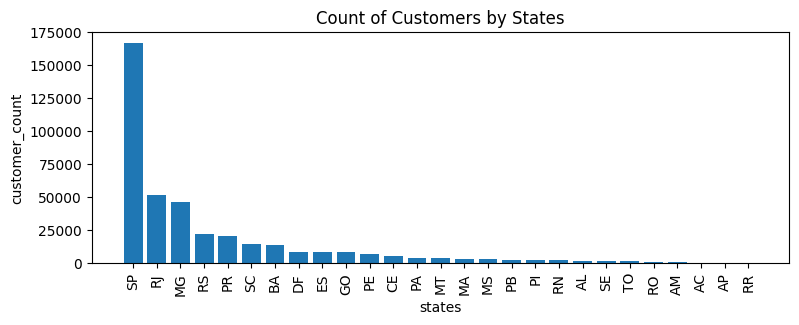

In [13]:
df = pd.DataFrame(data , columns = ["state", "customer_count" ])         #first x-axis & then y-axis
df = df.sort_values(by = "customer_count" , ascending = False)          #to have the sorted bar graph 

plt.figure(figsize = (9,3))                                         #figure size as (width, height)
plt.bar(df["state"], df["customer_count"])    
plt.xticks(rotation = 90)                                            #rotates the x-axis labels to 90 degrees

plt.xlabel("states")
plt.ylabel("customer_count")
plt.title("Count of Customers by States")

plt.show()                                                            #to show the bar plot

# Intermediates Questions 

# 1. Calculate the number of orders per month in 2018.

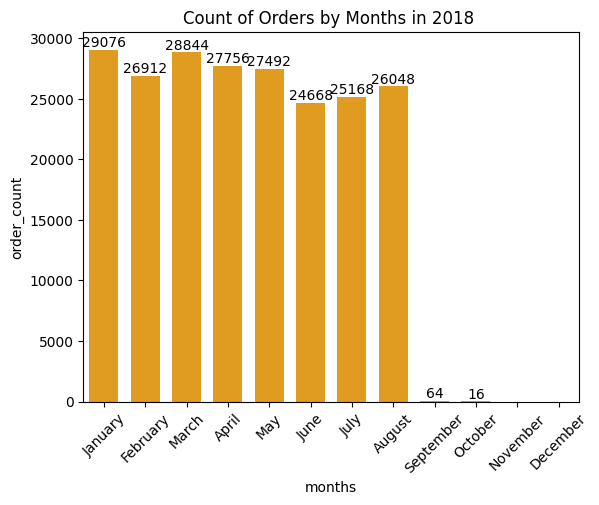

In [14]:
query = """ select monthname(order_purchase_timestamp) months, count(order_id) order_count 
from orders where year(order_purchase_timestamp) = 2018  
group by months   """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["months" , "order_count" ])
o = ["January", "February" , "March", "April", "May" , "June" , "July" , "August" , "September" , "October" , "November" , "December"]

ax = sns.barplot(x = df["months"], y = df["order_count"], data = df, order = o , color = "orange" , width=0.7)

plt.xticks(rotation = 45)                                            #rotates the x-axis labels to 45 degrees
ax.bar_label(ax.containers[0])

plt.title("Count of Orders by Months in 2018 ")
plt.show()

# 2. Find the average number of products per order, grouped by customer city.

In [15]:
query = """ WITH count_per_order AS
(SELECT orders.order_id, orders.customer_id, count(order_items.order_id) AS oc
FROM orders JOIN order_items
ON orders.order_id = order_items.order_id
GROUP BY orders.order_id, orders.customer_id)

SELECT customers.customer_city, round(avg(count_per_order.oc), 2) average_orders
FROM customers JOIN count_per_order
ON customers.customer_id = count_per_order.customer_id
GROUP BY customers.customer_city 
ORDER BY average_orders desc
;
  """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data , columns = ["customer city" , "average orders per order"])
df.head(10)

,customer city,average orders per order
0,padre carvalho,56.00
1,celso ramos,52.00
2,datas,48.00
3,candido godoi,48.00
4,matias olimpio,40.00
5,cidelandia,32.00
6,curralinho,32.00
7,picarra,32.00
8,morro de sao paulo,32.00
9,teixeira soares,32.00


# 3. Calculate the percentage of total revenue contributed by each product category.

In [16]:
query = """ select upper(products.product_category) category, 
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100 , 2) sales_percentage
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc

;
  """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data , columns = ["Category" , "Percentage distribution"])
df.head(10)

,Category,Percentage distribution
0,BED TABLE BATH,85.58
1,HEALTH BEAUTY,82.82
2,COMPUTER ACCESSORIES,79.22
3,FURNITURE DECORATION,71.47
4,WATCHES PRESENT,71.42
5,SPORT LEISURE,69.57
6,HOUSEWARES,54.71
7,AUTOMOTIVE,42.59
8,GARDEN TOOLS,41.89
9,COOL STUFF,38.96


# 4. Identify the correlation between product price and the number of times a product has been purchased.

In [17]:
query = """ select products.product_category,
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category;
;
  """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data , columns = ["Category" , "order_count" , "price"])

arr1 = df["order_count"]
arr2 = df["price"]

#A correlation ranges from -1 ( inversely proportional value )  to +1 ( directly proportional value ). 
# The +1 correlation means if one quantity increases other also increases in the same way
# The -1 correlation means if one quantity increases other decreases in the opposite way

a = np.corrcoef([arr1 , arr2])        

print("The correlation between product price and the number of times a product has been purchased is " , a[0][-1])

#result = There is no impact on order count based on price as the correlation is coming out to be nearly 0.10 
#which is very much close to zero that is a neutral value. 

The correlation between product price and the number of times a product has been purchased is  -0.10631514167157562


# 5. Calculate the total revenue generated by each seller, and rank them by revenue.

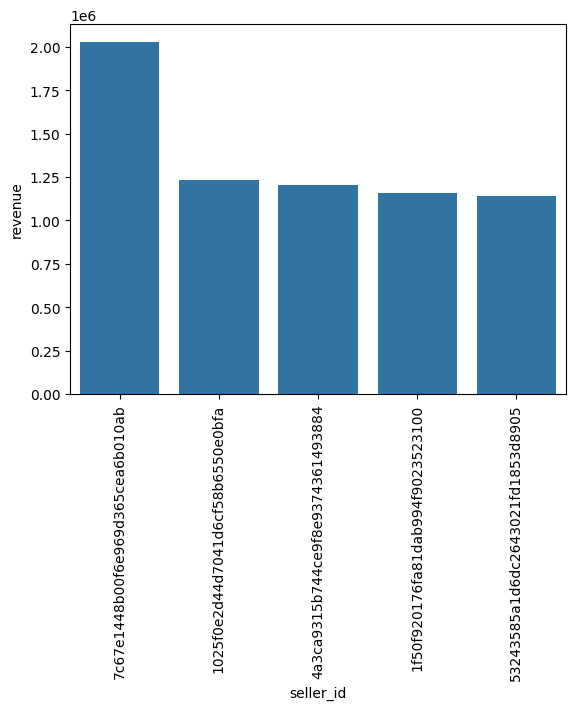

In [19]:
query = """ select * , dense_rank() over(order by revenue desc) as rn from
( select order_items.seller_id, sum(payments.payment_value) revenue
from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id ) as a

  """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data , columns = ["seller_id" , "revenue", "rank"])
df = df.head()
sns.barplot(x = "seller_id", y = "revenue" , data = df)
plt.xticks(rotation =90)
plt.show()

# ADVANCED QUESTIONS

# 1. Calculate the moving average of order values for each customer over their order history.

In [25]:
query = """  select customer_id, order_purchase_timestamp, payment ,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp,
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a;
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data , columns = ["customer_id", "order_purchase_timestamp", " payment" , "mov_avg"])
df.head(10)

,customer_id,order_purchase_timestamp,payment,mov_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
5,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
6,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
7,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
8,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
9,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004


# 2. Calculate the cumulative sales per month for each year.

In [34]:
query = """ select years, months, payment, sum(payment) over(partition by years order by months) as cumulative_sales 
 from ( select  
year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value), 2) as payment 
from orders 
join payments on orders.order_id = payments.order_id
group by years, months 
order by years, months) as a

"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["year", "months", "payment", "cumulative_sales"])
df

,year,months,payment,cumulative_sales
0,2016,9,2017.92,2017.92
1,2016,10,472723.84,474741.76
2,2016,12,156.96,474898.72
3,2017,1,1107904.32,1107904.32
4,2017,2,2335264.08,3443168.40
5,2017,3,3598908.80,7042077.20
6,2017,4,3342304.24,10384381.44
7,2017,5,4743350.56,15127732.00
8,2017,6,4090211.04,19217943.04
9,2017,7,4739063.36,23957006.40


# 3. Calculate the year-over-year growth rate of total sales.

In [42]:
query = """ with a as
(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value), 2) as payment 
from orders 
join payments on orders.order_id = payments.order_id
group by years
order by years )

select years, ((payment - lag(payment,1) over(order by years))/
lag(payment,1) over(order by years)) * 100 from a 

"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years" , "yoy % growth"])
df

,years,yoy % growth
0,2016,NaN
1,2017,12112.703759
2,2018,20.000924


# 4. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [45]:
query = """ 
with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id ) ,

b as (select a.customer_id, count(distinct(orders.order_purchase_timestamp)) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < date_add(first_order,interval 6 month)
group by a.customer_id)

select 100 * (count(distinct a.customer_id)/ count(distinct b.customer_id))
from a left join b
on a.customer_id = b.customer_id
;
"""

cur.execute(query)
data = cur.fetchall()
data     #result is NONE which means there is no repeated customer 

[(None,)]

# 5. Identify the top 3 customers who spent the most money in each year.

<function matplotlib.pyplot.show(close=None, block=None)>

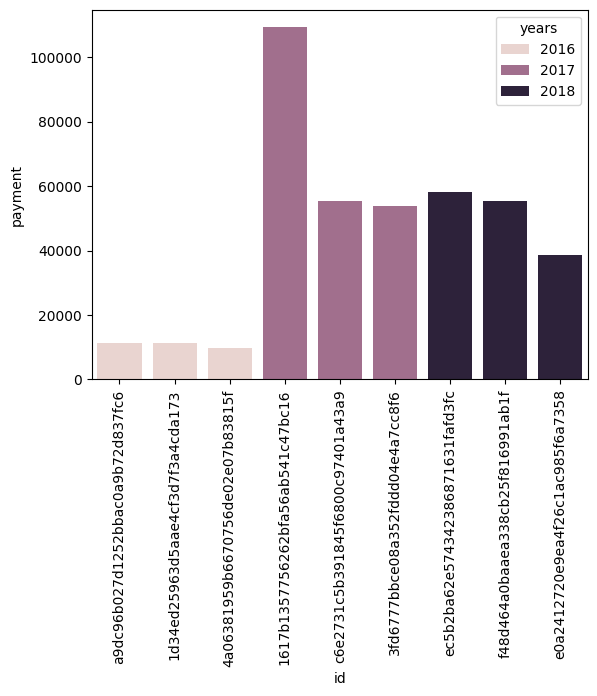

In [52]:
query = """ 
select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over( partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id ) as a
where d_rank <=3
;
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data ,columns = ["years" , "id" , "payment" ,"rank"])
df
sns.barplot(x = "id" , y = "payment" , data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show